Epoch 1/5 - Train Loss: 0.0865 - Test Loss: 0.0767
Epoch 2/5 - Train Loss: 0.0529 - Test Loss: 0.0763
Epoch 3/5 - Train Loss: 0.0496 - Test Loss: 0.0790
Epoch 4/5 - Train Loss: 0.0472 - Test Loss: 0.0804
Epoch 5/5 - Train Loss: 0.0450 - Test Loss: 0.0820


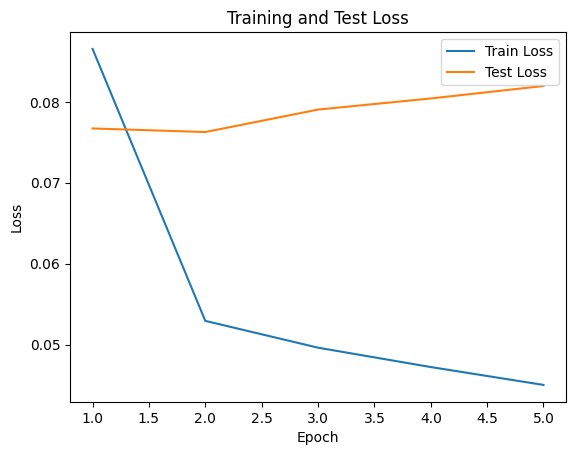

In [ ]:
# Cell 1: Training and saving model/graph

!pip install torch scikit-learn pandas matplotlib --quiet

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import pickle

# Load data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
test_labels_df = pd.read_csv('test_labels.csv')

# Filter valid test labels
test_labels_df = test_labels_df[test_labels_df['toxic'] != -1]
test_df = test_df[test_df['id'].isin(test_labels_df['id'])]

# Vectorize text
all_text = pd.concat([train_df['comment_text'], test_df['comment_text']])
vectorizer = TfidfVectorizer(max_features=3000, stop_words='english')
vectorizer.fit(all_text)

X_train = vectorizer.transform(train_df['comment_text']).toarray()
X_test = vectorizer.transform(test_df['comment_text']).toarray()

y_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y_train = train_df[y_cols].values
y_test = test_labels_df[y_cols].values

class ToxicDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(ToxicDataset(X_train, y_train), batch_size=128, shuffle=True)
test_loader = DataLoader(ToxicDataset(X_test, y_test), batch_size=128, shuffle=False)

class ToxicNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, output_dim)
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ToxicNet(X_train.shape[1], 6).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_losses, test_losses = [], []
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item() * X_batch.size(0)
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f} - Test Loss: {test_loss:.4f}")

# Save model weights
torch.save(model.state_dict(), "toxic_model_weights.pth")

# Save loss graph
plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss')
plt.savefig("loss_graph.png")
plt.show()

In [ ]:
# Cell 2: Save all parameters (metrics, model, optimizer, vectorizer, etc.)

import os
import pickle
import torch
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# Create folders if they don't exist
os.makedirs("metrics", exist_ok=True)
os.makedirs("weights", exist_ok=True)

# Evaluate on test set
model.eval()
all_outputs = []
all_labels = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        all_outputs.append(torch.sigmoid(outputs).cpu().numpy())
        all_labels.append(y_batch.cpu().numpy())
y_true = np.vstack(all_labels)
y_pred = (np.vstack(all_outputs) > 0.5).astype(int)

# Calculate metrics for each class and overall
metrics = {}
for i, col in enumerate(y_cols):
    metrics[col] = {
        "f1": f1_score(y_true[:, i], y_pred[:, i], zero_division=0),
        "precision": precision_score(y_true[:, i], y_pred[:, i], zero_division=0),
        "recall": recall_score(y_true[:, i], y_pred[:, i], zero_division=0),
        "accuracy": accuracy_score(y_true[:, i], y_pred[:, i])
    }
# Macro averages
metrics["macro_avg"] = {
    "f1": f1_score(y_true, y_pred, average="macro", zero_division=0),
    "precision": precision_score(y_true, y_pred, average="macro", zero_division=0),
    "recall": recall_score(y_true, y_pred, average="macro", zero_division=0),
    "accuracy": accuracy_score(y_true, y_pred)
}
# Micro averages
metrics["micro_avg"] = {
    "f1": f1_score(y_true, y_pred, average="micro", zero_division=0),
    "precision": precision_score(y_true, y_pred, average="micro", zero_division=0),
    "recall": recall_score(y_true, y_pred, average="micro", zero_division=0),
    "accuracy": accuracy_score(y_true, y_pred)
}

# Save metrics as CSV
import csv
with open("metrics/metrics.csv", "w", newline='') as csvfile:
    fieldnames = ["class", "f1", "precision", "recall", "accuracy"]
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for key, vals in metrics.items():
        row = {"class": key}
        row.update(vals)
        writer.writerow(row)

# Save model weights and optimizer state
torch.save(model.state_dict(), "weights/toxic_model_weights.pth")
torch.save(optimizer.state_dict(), "weights/optimizer_state.pth")

# Save vectorizer and model info
with open("weights/vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)
model_info = {
    "input_dim": X_train.shape[1],
    "output_dim": 6
}
with open("weights/model_info.pkl", "wb") as f:
    pickle.dump(model_info, f)
# ...existing code...

import matplotlib.pyplot as plt
import numpy as np

# Prepare data for plotting
metric_names = ["f1", "precision", "recall", "accuracy"]
class_names = y_cols + ["macro_avg", "micro_avg"]

for metric in metric_names:
    values = [metrics[c][metric] for c in class_names]
    plt.figure(figsize=(10, 5))
    bars = plt.bar(class_names, values, color='skyblue')
    plt.ylim(0, 1)
    plt.ylabel(metric.capitalize())
    plt.title(f"{metric.capitalize()} Score for Each Class")
    plt.xticks(rotation=45)
    # Annotate bars
    for bar, val in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, val + 0.01, f"{val:.2f}", ha='center', va='bottom')
    plt.tight_layout()
    plt.savefig(f"metrics/{metric}_barplot.png")
    plt.close()

print("All metric graphs saved in metrics/ folder.")
# ...existing code...
print("All metrics saved in metrics/metrics.csv")
print("Model weights, optimizer state, vectorizer, and model info saved in weights/")

All metrics saved in metrics/metrics.csv
Model weights, optimizer state, vectorizer, and model info saved in weights/


In [ ]:
# =========================
# 🔧 Testing & Adding Custom Weights for Toxic Comment Classification
# =========================

import torch
import pickle
import os
from sklearn.feature_extraction.text import TfidfVectorizer

# ----------- 🔁 User-defined paths (Modify these before running) ----------
VECTORIZER_PATH = "vectorizer.pkl"
MODEL_INFO_PATH = "model_info.pkl"
WEIGHTS_PATH = "toxic_model_weights.pth"

# ----------- 🧠 Define the Model Structure ----------
class ToxicNet(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_dim, 256)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(256, output_dim)
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# ----------- 🏷️ Label Names ----------
label_names = [
    "toxic",
    "severe toxic",
    "obscene",
    "threat",
    "insult",
    "identity hate"
]

# ----------- ⚙️ Load Components ----------
def load_components(vectorizer_path, model_info_path, weights_path):
    if not os.path.exists(vectorizer_path):
        raise FileNotFoundError(f"Vectorizer not found at {vectorizer_path}")
    with open(vectorizer_path, "rb") as f:
        vectorizer = pickle.load(f)

    if not os.path.exists(model_info_path):
        raise FileNotFoundError(f"Model info not found at {model_info_path}")
    with open(model_info_path, "rb") as f:
        model_info = pickle.load(f)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ToxicNet(model_info["input_dim"], model_info["output_dim"]).to(device)

    if not os.path.exists(weights_path):
        raise FileNotFoundError(f"Model weights not found at {weights_path}")
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.eval()

    return vectorizer, model, device

# ----------- 📊 Predict Toxic Labels ----------
def predict_toxic(comments, vectorizer, model, device):
    X = vectorizer.transform(comments).toarray()
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    with torch.no_grad():
        outputs = model(X_tensor)
        probs = torch.sigmoid(outputs).cpu().numpy()
    return probs

# ----------- 💬 Explanation ----------
def explain_prediction(comment, pred, threshold=0.5):
    labels = [label_names[i] for i, p in enumerate(pred) if p > threshold]
    if labels:
        return f'This comment is likely: {", ".join(labels)}.'
    else:
        return "This comment is likely not toxic."

# ----------- 🚀 Run Example Predictions ----------
if __name__ == "__main__":
    # Load model and vectorizer
    vectorizer, model, device = load_components(VECTORIZER_PATH, MODEL_INFO_PATH, WEIGHTS_PATH)

    # Sample test comments
    sample_comments = [
        "You are so stupid!",
        "Have a nice day!"
    ]

    # Predict
    predictions = predict_toxic(sample_comments, vectorizer, model, device)

    # Display Results
    for comment, pred in zip(sample_comments, predictions):
        print(f"\nComment: {comment}")
        print(explain_prediction(comment, pred))


Comment: You are so stupid!
This comment is likely: toxic, obscene, insult.
Comment: Have a nice day!
This comment is likely not toxic.
